<a href="https://colab.research.google.com/github/A01364577/Equipo_18_Navegacion_Autonoma/blob/main/Deteccion_se%C3%B1ales_transito_A01794099ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Maestria en Inteligencia Artificial Aplicada
##Navegación Autónoma
###Actividad 4.2 - Detección de Señales de Tránsito
Equipo 18:

- Laura Irán González Ojeda - A01794099
- Emmanuel Francisco González Velázquez - A01364577
- Fabiola Sosa Hernández- A01240145
- Jorge Fernández Lara - A01793062
- Jonathan Puga Castellanos - A01795204

In [19]:
# Importación de Librerías
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd

In [20]:
# Asegurarse de que se esté utilizando GPU
import tensorflow as tf
tf.test.gpu_device_name()
# Verificar si hay una GPU disponible
if tf.config.list_physical_devices('GPU'):
    print("GPU está disponible.")
    # Obtener detalles de la GPU
    for gpu in tf.config.list_physical_devices('GPU'):
        print(f"Nombre de la GPU: {gpu.name}")
else:
    print("No hay GPU disponible.")


GPU está disponible.
Nombre de la GPU: /physical_device:GPU:0


In [21]:
# Cargar el archivo .json con el token de Kaggle y utilizar la API de Kaggle para descargar el archivo .zip del dataset
from google.colab import files
files.upload()

# Crear el directorio .kaggle y mover el archivo kaggle.json allí
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Instalar la API de Kaggle
!pip install kaggle

# Descargar el archivo del conjunto de datos de Kaggle
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign  --unzip -p /content/gtsrb

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
100% 611M/612M [00:30<00:00, 24.0MB/s]
100% 612M/612M [00:30<00:00, 21.3MB/s]


In [22]:
#Se definen los nombres de las clases:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles', 16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

In [23]:
data_dir = '/content/gtsrb'
train_path = '/content/gtsrb/Train'
test_path = '/content/gtsrb'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [24]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

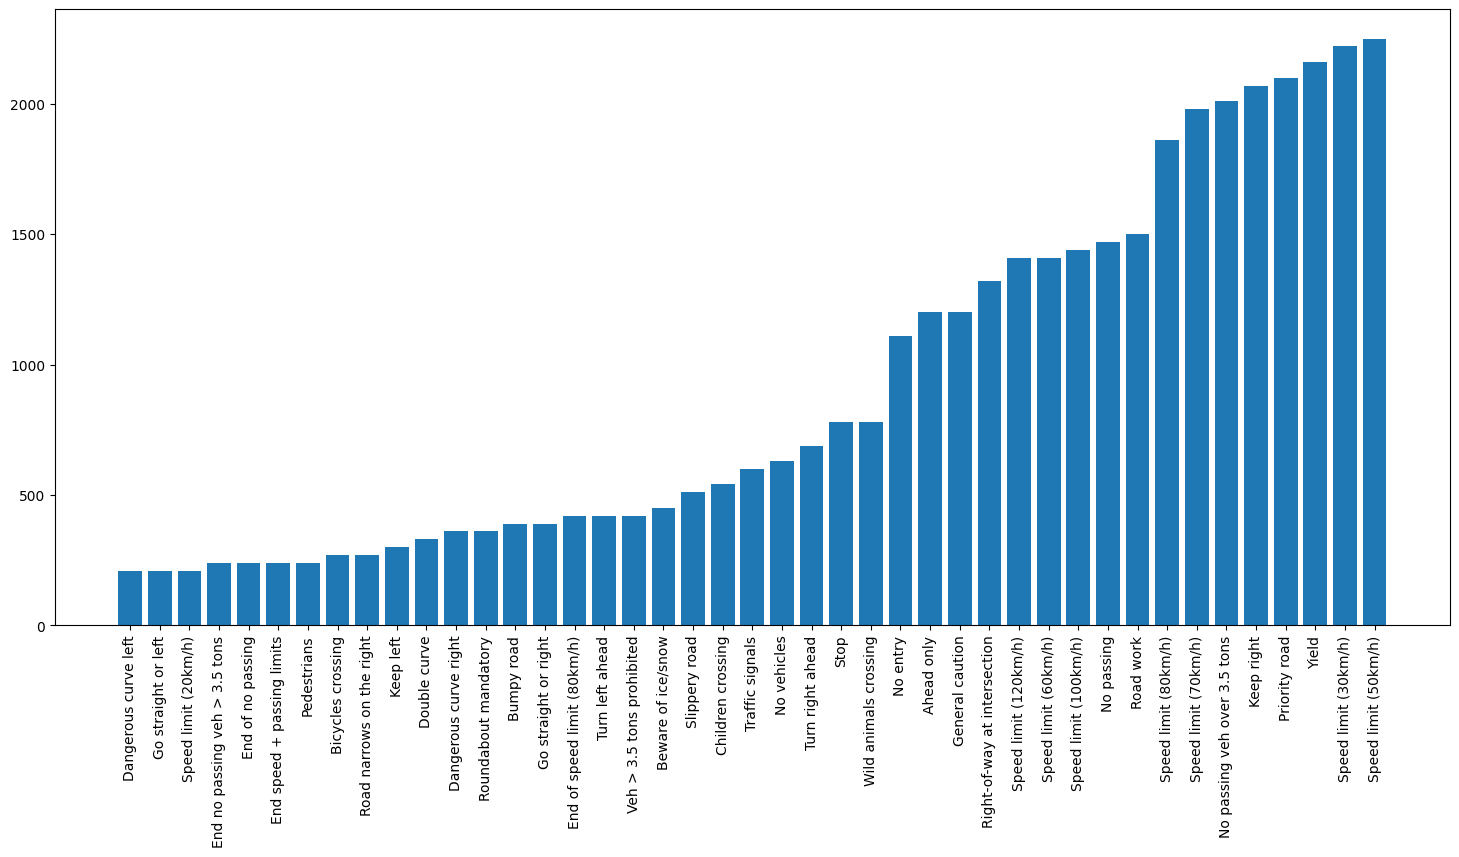

In [25]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Ordenar el conjunto de datos según el número de imágenes de cada clase
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Visualizar el número de imágenes en cada clase
plt.figure(figsize=(18,8))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

In [26]:
#Procesamiento de los datos para obtener los datos de entrenamiento
image_data = []
image_labels = []
for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)
    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)
# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)
print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [27]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [28]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)

In [29]:
#Segmentacion de los datos para el conjunto de entrenamiento, validacion y pruebas
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

X_test = np.array(data)
X_test = X_test / 255

print("Dimensiones X_train", X_train.shape)
print("Dimensiones X_valid ", X_val.shape)
print("Dimensiones y_train", y_train.shape)
print("Dimensiones y_valid", y_val.shape)
print("Dimensiones X_test", X_test.shape)

Dimensiones X_train (27446, 30, 30, 3)
Dimensiones X_valid  (11763, 30, 30, 3)
Dimensiones y_train (27446,)
Dimensiones y_valid (11763,)
Dimensiones X_test (12630, 30, 30, 3)


In [30]:
keras = tf.keras
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [31]:
# Creación del modelo de red neuronal
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization(axis=-1))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization(axis=-1))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(43, activation='softmax'))

In [32]:
#Optimizador del modelo
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 13, 13, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 9, 9, 128)        

In [33]:
#Aplicar técnicas de aumento en los datos para lograr mayor precisión en la red neuronal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [34]:
epochs=20
batch_size=32
# Entrenamiento del modelo
history = model.fit(aug.flow( X_train,y_train),
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=2
                    )

Epoch 1/20
858/858 - 28s - loss: 1.0724 - accuracy: 0.7143 - val_loss: 0.1148 - val_accuracy: 0.9628 - 28s/epoch - 33ms/step
Epoch 2/20
858/858 - 19s - loss: 0.1860 - accuracy: 0.9435 - val_loss: 0.0363 - val_accuracy: 0.9888 - 19s/epoch - 22ms/step
Epoch 3/20
858/858 - 20s - loss: 0.1033 - accuracy: 0.9694 - val_loss: 0.0638 - val_accuracy: 0.9778 - 20s/epoch - 23ms/step
Epoch 4/20
858/858 - 24s - loss: 0.0906 - accuracy: 0.9722 - val_loss: 0.0471 - val_accuracy: 0.9838 - 24s/epoch - 29ms/step
Epoch 5/20
858/858 - 24s - loss: 0.0745 - accuracy: 0.9768 - val_loss: 0.0119 - val_accuracy: 0.9964 - 24s/epoch - 28ms/step
Epoch 6/20
858/858 - 20s - loss: 0.0640 - accuracy: 0.9802 - val_loss: 0.0342 - val_accuracy: 0.9880 - 20s/epoch - 24ms/step
Epoch 7/20
858/858 - 19s - loss: 0.0639 - accuracy: 0.9810 - val_loss: 0.0313 - val_accuracy: 0.9905 - 19s/epoch - 22ms/step
Epoch 8/20
858/858 - 18s - loss: 0.0629 - accuracy: 0.9814 - val_loss: 0.0153 - val_accuracy: 0.9955 - 18s/epoch - 21ms/step


In [35]:
#Visualizar la precisión y la pérdida durante el entrenamiento de la red neuronañ.
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10,5))

    # Visualizar el accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Visualizar la pérdida
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

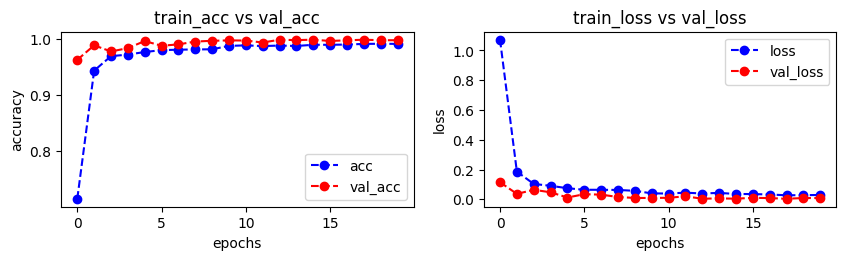

In [36]:
plot_accuracy_loss(history)

In [38]:
#Comprobar aprendizaje y precisión del modelo con datos de test

from sklearn.metrics import accuracy_score
pred_probabilities = model.predict(X_test)
pred_classes = np.argmax(pred_probabilities, axis=-1)

# Accuracy with the test data
print('Test Data accuracy: ', accuracy_score(labels, pred_classes) * 100)

395/395 [==============================] - 2s 5ms/step
Test Data accuracy:  97.8701504354711
